In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Data Cleaning & Preprocessing


**Loading the Data**:-
* We start by loading customer transaction data into a Pandas DataFrame, which is our workspace to sort, clean, and transform.
* Here, each row tells a story of a single transaction, and every column holds essential details like who sent the money, where it’s going, and even how much was involved.

**Removing the “Incomplete” Transactions**:-
* A transaction with missing pieces—like not knowing the sender or the recipient, these are essential elements for our analysis, so we drop any rows missing these critical fields.
* We save these dropped rows aside in a separate file (*dropped_Bank_Cln.csv*).

**Ensuring Unique Transactions:**
* Each transaction should have a unique ID (*request_id*).
* If any transaction seems to repeat itself, we remove the duplicate to avoid skewing our results.

**Tidying Up Country Codes:**
* Country codes can be a bit messy, so we make sure they’re all formatted consistently. For example, we turn long descriptions like “VietnamEarthportRecipient” into simple codes like “VN.”

**Filling in Missing Values with Defaults:**
* If the invoice_value or invoice_value_cancel fields are blank, we fill them with a zero.
* For fields like *transfer_sequence* and *days_since_previous_req*, we replace any blanks with zero and make sure they’re formatted as whole numbers—clean and ready for calculations.
* We also handle *payment_type* carefully, replacing blanks with "NULL". This way, when we dive deeper, we’ll know exactly when a payment type was unknown, making our analysis more transparent.

**Calculating Account Age:**
* By calculating the number of days since each account was created (*days_account_created*), we get a sense of user tenure. Younger accounts can sometimes be a red flag, so this data will be valuable for later stages.

**Saving the Cleaned Data:**
* After all these adjustments, we save our cleaned dataset as *Bank_Cln.csv*.
* We also keep the dropped rows for reference in *dropped_Bank_Cln.csv*, completing our cleanup.

In the below cell- please update the path of the orignial source file that was given as a part of this case study.

We will only need to provide this information once and then all the cells will pickup the relevant information and give us output files as saided in the ppt presentation.

In [2]:
File_Path = '/content/Servicing - Product homework dataset.csv'

In [3]:

# Load dataset
data = pd.read_csv(File_Path)

# Data Cleaning Steps
# 1. Remove rows where user_id, request_id, or target_recipient_id are NULL
cleaned_data = data.dropna(subset=['user_id', 'request_id', 'target_recipient_id'])
dropped_data = data[~data.index.isin(cleaned_data.index)]

# 2. Check for unique request_id and drop duplicates if any
cleaned_data = cleaned_data.drop_duplicates(subset=['request_id'])

# 3. Ensure addr_country_code is in 3-letter code
cleaned_data.loc[:, 'addr_country_code'] = cleaned_data['addr_country_code'].apply(lambda x: x[:3] if len(x) == 3 else np.nan)

# 4. Correct recipient_country_code to 2-letter codes for specific cases
country_corrections = {
    'VietnamEarthportRecipient': 'VN', 'SriLankaLocalRecipient': 'SL',
    'JapaneseLocal': 'JP', 'BangladeshLocalRecipient': 'BN'
}
cleaned_data.loc[:, 'recipient_country_code'] = cleaned_data['recipient_country_code'].replace(country_corrections)

# 5. Filter out rows where recipient_country_code has specific values that require additional information
special_recipient_conditions = cleaned_data['recipient_country_code'].isin(['EmptyRecipient', 'EmailRecipient', 'BalanceRecipient'])
dropped_data = pd.concat([dropped_data, cleaned_data[special_recipient_conditions]])
cleaned_data = cleaned_data[~special_recipient_conditions]

# 6. Ensure recipient_country_code takes only 2-letter alpha codes
cleaned_data.loc[:, 'recipient_country_code'] = cleaned_data['recipient_country_code'].apply(lambda x: x if len(x) == 2 and x.isalpha() else np.nan)

# 7. Replace blank invoice_value and invoice_value_cancel with 0
cleaned_data.loc[:, 'invoice_value'] = cleaned_data['invoice_value'].fillna(0)
cleaned_data.loc[:, 'invoice_value_cancel'] = cleaned_data['invoice_value_cancel'].fillna(0)

# 8. Replace NULLs in transfer_sequence and days_since_previous_req with 0, convert to integers, and round to whole numbers
cleaned_data[['transfer_sequence', 'days_since_previous_req']] = (
    cleaned_data[['transfer_sequence', 'days_since_previous_req']].fillna(0).astype(int).round(0))

# 9. Replace blank payment_type with "NULL"
cleaned_data.loc[:, 'payment_type'] = cleaned_data['payment_type'].fillna("NULL")

# 10. Calculate account age in days, specifying dayfirst=True for date format
cleaned_data.loc[:, 'days_account_created'] = (pd.to_datetime('today') - pd.to_datetime(cleaned_data['date_user_created'], dayfirst=True)).dt.days

# Save cleaned data and dropped rows
cleaned_data.to_csv("Bank_Cln.csv", index=False)
dropped_data.to_csv("dropped_Bank_Cln.csv", index=False)

print("Data cleaning complete. Cleaned data saved to 'Bank_Cln.csv' and dropped rows saved to 'dropped_Bank_Cln.csv' for further analysis")


<ipython-input-3-5331a916fd65>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data[['transfer_sequence', 'days_since_previous_req']] = (


Data cleaning complete. Cleaned data saved to 'Bank_Cln.csv' and dropped rows saved to 'dropped_Bank_Cln.csv' for further analysis


# Feature Engineering

**Load and Set Up the Data:**
We start by loading the dataset, Bank_Cln.csv, which has transaction details and user information that we need to assess each transaction’s risk level.

**Calculate Unique Devices and Payment Types:**
For each user, we calculate the number of unique devices and payment types they've used. A higher number of unique devices or payment methods might suggest unusual behavior, like potential fraud or account sharing.
These counts are added back to the main dataset, providing more context about each transaction.

**List of High-Risk Countries:**
We create two lists: one for high-risk recipient countries and one for high-risk sender countries. These contain country codes that we consider risky, helping us identify transactions that might be associated with suspicious regions.

**Define the Risk Scoring Function:**
This function assigns a risk score to each transaction by looking at a variety of red flags. Each risk factor has a specific weight that reflects its risk level.

1. **High-Risk Country Checks:**
If a transaction involves a high-risk recipient or sender country, it’s assigned a significant score, as it may involve a risky region.

2. **Unknown Bank Information:**
Transactions from unknown banks or countries flagged as "Other/unknown" get a score, as reputable transactions generally come from known institutions.

3. **Transfers to Self with Unknown Recipients**:Transfers made to oneself, especially with unknown recipient details, can be a red flag for hidden or suspicious transactions.

4. **Extended Transaction Delays:**
Transactions with more than seven days between setup and reception are flagged, as delays may indicate non-standard or suspicious processing.

5. **Inconsistent Personal Payments:**
If a transaction is marked “personal” but the recipient details suggest it’s sent to a business, this inconsistency is flagged for review.

6. **Missing Payment Type:**
Missing payment type details (marked as "NULL") are flagged, as unknown payment methods can indicate hidden risks.

7. **Long Gaps Between Transactions:** If more than 90 days have passed since the last transaction, this one is flagged; sporadic use might suggest suspicious activity.

8. **Multiple Payment Types:**If a user uses more than three payment types, this is flagged, as using many different payment methods can suggest unusual account behavior.

9. **High Invoice Value:**
Transactions above 25,000 are flagged for additional scrutiny, as they involve larger amounts and may require more oversight.

10. **Use of Multiple Devices**:
Using more than three devices triggers a flag, as this could indicate account sharing or an attempt to evade detection.

11. **High Transfer Sequence for Personal Accounts:**If a personal account has more than 4500 transfers, it’s flagged; this activity level is unusual for personal use and could indicate business or other suspicious activity.

12. **Unknown Payment Reference:**
If a transaction has an "Other/unknown" or blank payment reference, this is flagged, as the transaction’s purpose is unclear.

13. **New Users:**
Users with accounts less than 15 days old are flagged, as new users may pose a higher risk due to limited activity history.

In [4]:
# Load the dataset

cleaned_data = pd.read_csv('/content/Bank_Cln.csv')

# Calculate unique devices and payment types per user
device_counts = cleaned_data.groupby('user_id')['device'].nunique().reset_index(name='unique_devices')
payment_type_counts = cleaned_data.groupby('user_id')['payment_type'].nunique().reset_index(name='unique_payment_types')

# Merge with cleaned data
cleaned_data = cleaned_data.merge(device_counts, on='user_id', how='left')
cleaned_data = cleaned_data.merge(payment_type_counts, on='user_id', how='left')

# Define high-risk countries
high_risk_countries = ['BG', 'BF', 'CM', 'HR', 'KP', 'CD', 'HT', 'IR', 'JM', 'KE', 'ML', 'MZ', 'MM', 'NA', 'NG', 'PH', 'SN', 'ZA', 'SS', 'SY', 'TZ', 'TR', 'VN', 'YE']
high_risk_sender_countries = ['BGR', 'BFA', 'CMR', 'HRV', 'PRK', 'COD', 'HTI', 'IRN', 'JAM', 'KEN', 'MLI', 'MOZ', 'MMR', 'NAM', 'NGA', 'PHL', 'SEN', 'ZAF', 'SSD', 'SYR', 'TZA', 'TUR', 'VNM', 'YEM']

# Define the risk scoring function
def calculate_risk_score(row):
    score = 0

    # High-risk recipient country
    if row['recipient_country_code'] in high_risk_countries:
        score += 10

    # High-risk sender country
    if row['addr_country_code'] in high_risk_sender_countries:
        score += 9

    # Unknown bank name or country
    if row['sending_bank_name'] == "Other/unknown" or row['sending_bank_country'] == "Other/unknown":
        score += 8

    # Self-transfer with unknown recipient
    if row['transfer_to_self'] == "N.A. Recipient Email Unknown":
        score += 7

    # Delay over 7 days between submission and received date
    delay = (pd.to_datetime(row['date_request_received'], dayfirst=True) - pd.to_datetime(row['date_request_submitted'], dayfirst=True)).days
    if delay > 7:
        score += 7

    # Inconsistent personal payment
    if row['flag_personal_business'] == "personal" and row['transfer_to_self'] == "N.A. Sender or Recipient is business":
        score += 7

    # Missing payment type
    if row['payment_type'] == "NULL":
        score += 6

    # High days since previous request
    if row['days_since_previous_req'] > 90:
        score += 4

    # Payment type variations
    if row['unique_payment_types'] > 3:
        score += 4

    # If invoice value exceeds 25,000
    if row['invoice_value'] > 25000:
        score += 3

    # Multiple devices used
    if row['unique_devices'] > 3:
        score += 3

    # High transfer sequence
    if row['transfer_sequence'] > 4500 and row['flag_personal_business'] == "personal":
        score += 3

    # Unknown payment reference
    if row['payment_reference_classification'] == "Other/unknown" or row['payment_reference_classification'] == "blank":
        score += 2

    # New user
    if row['days_account_created'] < 15:
        score += 2

    return score




### Calculating Risk Score for each **Transaction** by developing a custom scoring function

**Classifying Risk Levels:**
* Using the *classify_risk* function, we assign each transaction a risk label based on its score. This step is simple but powerful—it lets us quickly see which transactions are low, medium, or high risk.

1.   **High Risk:** Scores of 25 or above.
2.   **Medium Risk:** Scores between 15 and 25.
1.   **Low Risk:** Scores below 15.

**Saving the Final Dataset:**
* With risk scores and classifications in place, we save our finished dataset as *final_output_bank_cln.csv*. This file includes everything we’ve calculated, giving a clear view of transaction risk levels. This file will be further reviewed to understand customer behaviour, and understand what kind of limits/restrictions would we need to set to catch any potential bad customers.

In [5]:
# Apply the scoring function
cleaned_data['transaction_risk_score'] = cleaned_data.apply(calculate_risk_score, axis=1)

# Classify risk based on the score
def classify_risk(score):
    if score > 25:
        return 'High'
    elif 15 <= score <= 25:
        return 'Medium'
    else:
        return 'Low'

cleaned_data['transaction_risk_factor'] = cleaned_data['transaction_risk_score'].apply(classify_risk)

# Save the final dataset with risk calculations
cleaned_data.to_csv("Bank_Presented.csv", index=False)


### Calculating **Customer** Risk Score


Using the above risk score for which is set at a trsansaction level, we now need to understand the risk score at a higher grain- customer level risk score.

**Calculating Customer-Level Aggregates**
* avg_risk_score: We use .mean() with lambda x: round(x.mean()) to get a whole-number average risk score for each user.

* total_transactions: Using .count() gives the total transactions per user_id, which helps gauge transaction frequency.
A high count might indicate regular use, while fewer transactions could hint at sporadic behavior.

* has_high_risk: This lambda function checks if a user has any "High" risk transactions.
 * If they do, it returns True, which lets us immediately label the customer as "High" risk in the next step.

**Assigning the Customer’s Overall Risk Factor**

* Vectorized Assignment of Customer Risk Factor: Using apply() with a single, structured lambda function efficiently assigns each customer’s risk level in one go.
 * If has_high_risk is True, the customer is labeled "High" risk immediately.
  Otherwise, the decision is based on avg_risk_score:

    1. High Risk: Scores of 25 or above.
    2. Medium Risk: Scores between 15 and 25.
    1. Low Risk: Scores below 15

* Dropping has_high_risk: Once the Customer Risk Factor is assigned, we drop has_high_risk to tidy up and reduce memory usage.

**Merging Summary Back to the Original Data**

* Adding Columns to Original Data: By merging user_summary back into data, we add *avg_risk_score*, *total_transactions*, and *customer_risk_factor* for each transaction.
  * This approach keeps transaction-level detail while providing an easy overview of each customer’s overall risk profile.

**Save and Output**

Saving as *final_output_customer_risk.csv:*

We save everything to a new file, so the detailed transaction data and customer-level summaries are easy to access and review.

In [6]:
import pandas as pd

# Load the final dataset with risk classifications
data = pd.read_csv("Bank_Presented.csv")

# Step 1: Calculate the average risk score (rounded) and total transactions per user
user_summary = data.groupby('user_id').agg(
    avg_risk_score=('transaction_risk_score', lambda x: round(x.mean())),
    total_transactions=('user_id', 'count'),
    has_high_risk=('transaction_risk_factor', lambda x: "High" in x.values)
).reset_index()

# Step 2: Assign Customer Risk Factor based on conditions
# If `has_high_risk` is True, assign "High" to Customer Risk Factor
user_summary['customer_risk_factor'] = user_summary.apply(
    lambda row: "High" if row['has_high_risk'] else (
        "High" if row['avg_risk_score'] > 25 else (
            "Medium" if row['avg_risk_score'] >= 15 else "Low"
        )
    ),
    axis=1
)

# Drop `has_high_risk` as it's no longer needed
user_summary = user_summary.drop(columns=['has_high_risk'])

# Step 3: Merge user summary back with the original data
data = data.merge(user_summary[['user_id', 'avg_risk_score', 'total_transactions', 'customer_risk_factor']],
                  on='user_id', how='left')

# Save the updated dataset
data.to_csv("final_output_customer_risk.csv", index=False)

# Output the updated dataset for download
from IPython.display import FileLink
FileLink("final_output_customer_risk.csv")

print("Optimized dataset with customer-level risk classification saved as 'final_output_customer_risk.csv'")


Optimized dataset with customer-level risk classification saved as 'final_output_customer_risk.csv'


## POC - CUSTOMIZED CHAT BOT
The below chat bot has been created to identify more information regarding risk factor and there proposed solution for individual customers.

After running this cell, we will need to provide one user_id taken from the final_output_customer_risk.csv and we will get their risk factor, why they got the relevant risk factor and potential mitigation suggestions.

To exit the loop, we will need to type "exit" in the input box.


In [8]:
!pip install pycountry
import pandas as pd
import pycountry
from IPython.display import display

# Define high-risk countries and conditions
high_risk_countries = ['BG', 'BF', 'CM', 'HR', 'KP', 'CD', 'HT', 'IR', 'JM', 'KE', 'ML', 'MZ', 'MM', 'NA', 'NG', 'PH', 'SN', 'ZA', 'SS', 'SY', 'TZ', 'TR', 'VN', 'YE']
high_risk_sender_countries = ['BGR', 'BFA', 'CMR', 'HRV', 'PRK', 'COD', 'HTI', 'IRN', 'JAM', 'KEN', 'MLI', 'MOZ', 'MMR', 'NAM', 'NGA', 'PHL', 'SEN', 'ZAF', 'SSD', 'SYR', 'TZA', 'TUR', 'VNM', 'YEM']

# Function to convert country codes to full country names
def get_country_name(code):
    try:
        # Try 2-letter alpha code
        country = pycountry.countries.get(alpha_2=code)
        if country:
            return country.name
        # Try 3-letter alpha code
        country = pycountry.countries.get(alpha_3=code)
        if country:
            return country.name
    except:
        return code  # Return the code if it cannot be converted

# Function to analyze user risk and generate recommendations
def analyze_user_risk(user_id, data):
    # Filter data for the specific user_id
    user_data = data[data['user_id'] == user_id]

    # Check if the user exists in the data
    if user_data.empty:
        return f"No data found for user ID: {user_id}"

    # Retrieve the customer's overall risk factor and total transactions
    customer_risk_factor = user_data['customer_risk_factor'].iloc[0]
    total_transactions = len(user_data)

    # Display customer-level information
    output = f"User ID {user_id} - customer_risk_factor: {customer_risk_factor}\n"
    output += f"Total Transactions: {total_transactions}\n\n"

    # Iterate through each transaction for the user
    for idx, row in user_data.iterrows():
        transaction_risk_conditions = []
        transaction_recommendations = []

        # Transaction-specific risk analysis
        # High-risk recipient country
        if row['recipient_country_code'] in high_risk_countries:
            country_name = get_country_name(row['recipient_country_code'])
            transaction_risk_conditions.append(f"Sent money to a high-risk recipient country: {country_name}.")
            transaction_recommendations.append("Understand from the customer the reason for their transaction.")

        # Missing or suspicious payment type
        if row['payment_type'] == "NULL":
            transaction_risk_conditions.append("Used a missing or suspicious payment type.")
            transaction_recommendations.append("Ensure payment types are verified and not left blank.")

        # Delay in transfer processing
        delay = (pd.to_datetime(row['date_request_received'], dayfirst=True) - pd.to_datetime(row['date_request_submitted'], dayfirst=True)).days
        if delay > 5:
            transaction_risk_conditions.append("Experienced a delay over 5 days between setting up the transfer and receiving funds.")
            transaction_recommendations.append("Follow up promptly on delayed transfers to minimize suspicious activity.")

        # Self-transfer with unknown recipient
        if row['transfer_to_self'] == "N.A. Recipient Email Unknown":
            transaction_risk_conditions.append("Sent a self-transfer to an unknown recipient.")
            transaction_recommendations.append("Verify recipient information to avoid sending funds to unverified recipients.")

        # Inconsistent personal payment flag
        if row['flag_personal_business'] == "personal" and row['transfer_to_self'] == "N.A. Sender or Recipient is business":
            transaction_risk_conditions.append("Sent money marked as personal to a business recipient.")
            transaction_recommendations.append("Clarify the intended recipient type to avoid mismatches in payment type.")

        # Low transfer sequence
        if row['transfer_sequence'] < 3:
            transaction_risk_conditions.append("Made only a few transfers, relatively new to the platform.")
            transaction_recommendations.append("Keep an eye out for such customers if they are flagged in high-risk.")

        # High days since previous request
        if row['days_since_previous_req'] > 10:
            transaction_risk_conditions.append("Shows sporadic transfer behavior with long intervals between requests.")
            transaction_recommendations.append("Keep an eye out for such customers if they are flagged in high-risk.")

        # High-risk sender country
        if row['addr_country_code'] in high_risk_sender_countries:
            sender_country_name = get_country_name(row['addr_country_code'])
            transaction_risk_conditions.append(f"Sent money from a high-risk sender country: {sender_country_name}.")
            transaction_recommendations.append("Understand from the customer the reason for their transaction.")

        # Multiple devices used
        if row['unique_devices'] > 2:
            transaction_risk_conditions.append("Used multiple devices, which may suggest account sharing or security evasion.")
            transaction_recommendations.append("Limit account access to a single, verified device for security.")

        # Variations in payment type
        if row['unique_payment_types'] > 1:
            transaction_risk_conditions.append("Used different payment types, which may indicate fraudulent behavior or account compromise.")
            transaction_recommendations.append("Keep an eye out for such customers if they are flagged in high-risk.")

        # Unknown bank or country in sender details
        if row['sending_bank_name'] == "Other/unknown" or row['sending_bank_country'] == "Other/unknown":
            transaction_risk_conditions.append("Used an unknown bank or country for sending funds.")
            transaction_recommendations.append("Clarify the details from the customer regarding the sending bank name and country.")

        # Unknown payment reference
        if row['payment_reference_classification'] == "Other/unknown" or row['payment_reference_classification'] == "blank":
            transaction_risk_conditions.append("Customer has missing payment reference details.")
            transaction_recommendations.append("Clarify the details from the customer regarding the reason for payment.")

        # High transfer sequence
        if row['transfer_sequence'] > 4500 and row['flag_personal_business'] == "personal":
           transaction_risk_conditions.append("Extremely high number of transactions made by customer for personal usage")
           transaction_recommendations.append("Do impromptu checks to understand the reason for high transactions after the threshold limit.")

        # New user
        if row['days_account_created'] < 30:
            transaction_risk_conditions.append("Account is newly created.")
            transaction_recommendations.append("Keep an eye out for such customers if they are flagged in high-risk.")

        # Display each transaction's risk conditions and recommendations
        output += f"Transaction ID: {row['request_id']}\n"
        output += "Risk Conditions:\n"
        for condition in set(transaction_risk_conditions):
            output += f"• {condition}\n"

        output += "Recommendations:\n"
        for recommendation in set(transaction_recommendations):
            output += f"• {recommendation}\n"
        output += "\n"  # Add spacing between transactions

    return output

# Load the dataset as the database
data = pd.read_csv("final_output_customer_risk.csv")

# App structure to keep checking different User IDs
while True:
    # Prompt for user input
    user_id = input("Enter the User ID to analyze risk factors (or type 'exit' to quit): ")

    if user_id.lower() == 'exit':
        break

    # Analyze and display the risk conditions for the user
    result = analyze_user_risk(user_id, data)
    print(result)
    print("\n" + "-"*50 + "\n")  # Separator for readability


Enter the User ID to analyze risk factors (or type 'exit' to quit): ffc2627bf87d41c17f2468c95eb63267
User ID ffc2627bf87d41c17f2468c95eb63267 - customer_risk_factor: Low
Total Transactions: 1

Transaction ID: 29a1efff60b022aa17e82d294b7eddc1
Risk Conditions:
• Used an unknown bank or country for sending funds.
• Customer has missing payment reference details.
• Made only a few transfers, relatively new to the platform.
Recommendations:
• Keep an eye out for such customers if they are flagged in high-risk.
• Clarify the details from the customer regarding the sending bank name and country.
• Clarify the details from the customer regarding the reason for payment.



--------------------------------------------------

Enter the User ID to analyze risk factors (or type 'exit' to quit): exit


## Analysis


 1. Understanding the total sum of transactions made by all the customers. (rounded to a whole number)

In [10]:
# Load the dataset
data = pd.read_csv("final_output_customer_risk.csv")

# Calculate the sum of all transactions in the invoice_value column
total_invoice_value = round(data['invoice_value'].sum())

print(f"The total sum of all transactions (invoice_value) is: {total_invoice_value}")


The total sum of all transactions (invoice_value) is: 108592759


2. Obtaining the total unique countries money was transfered to by the customers

In [11]:
# Load the dataset
data = pd.read_csv("final_output_customer_risk.csv")

# Get the distinct countries in recipient_country_code
distinct_countries = data['recipient_country_code'].dropna().unique()
total_distinct_countries = len(distinct_countries)

print(f"Total count of distinct countries in recipient_country_code: {total_distinct_countries}")
print("List of distinct countries:", distinct_countries)


Total count of distinct countries in recipient_country_code: 65
List of distinct countries: ['GB' 'US' 'PT' 'IN' 'BG' 'SE' 'PL' 'HU' 'BE' 'AU' 'FR' 'NZ' 'IE' 'DE'
 'NL' 'CZ' 'ES' 'RO' 'AT' 'BR' 'CA' 'IT' 'HR' 'CY' 'PH' 'MX' 'SK' 'FI'
 'EE' 'AE' 'GR' 'LV' 'DK' 'NO' 'ID' 'TR' 'TH' 'CH' 'KR' 'ZA' 'MY' 'SG'
 'PK' 'NG' 'HK' 'LT' 'SI' 'RU' 'BN' 'UA' 'GE' 'CN' 'MA' 'MT' 'CO' 'LU'
 'CL' 'SL' 'JP' 'GI' 'VN' 'MC' 'IS' 'SM' 'AL']


3. Year-over-Year % Change in Customer Risk Factors:


In [12]:
# Extract year from date_request_submitted
data['Year'] = pd.to_datetime(data['date_request_submitted'], format="%d/%m/%Y %H:%M").dt.year

# Count the number of customers in each risk factor by year
yearly_risk_counts = data.groupby(['Year', 'customer_risk_factor']).size().unstack()

# Calculate YoY percentage change
yearly_risk_yoy = yearly_risk_counts.pct_change().fillna(0) * 100
print("Year-over-Year % Change in Customer Risk Factors:\n", yearly_risk_yoy)


Year-over-Year % Change in Customer Risk Factors:
 customer_risk_factor         High         Low       Medium
Year                                                      
2011                     0.000000    0.000000     0.000000
2012                     0.000000  269.444444  1033.333333
2013                     0.000000  817.293233   391.176471
2014                  1250.000000  551.557377   455.688623
2015                   714.814815  249.729526   218.857759
2016                    25.454545   91.989209    31.666103


4. Multiple analysis around high-risk customers

In [13]:
#% of customers in each risk factor
total_customers = data['user_id'].nunique()
risk_factor_counts = data.groupby('customer_risk_factor')['user_id'].nunique()
risk_factor_percentage = (risk_factor_counts / total_customers) * 100
print("Percentage of customers in each risk factor:")
print(risk_factor_percentage)

# Average YoY % change in customer risk factors
# Assuming there's a 'year' column in the data that represents the transaction year
yearly_risk_factor_counts = data.groupby(['date_request_submitted', 'customer_risk_factor'])['user_id'].nunique().unstack()
yearly_change = yearly_risk_factor_counts.pct_change().mean() * 100
print("\nAverage YoY % change in customer risk factors:")
print(yearly_change)

# Total invoice_value flagged as "High"
total_invoice_high = data.loc[data['customer_risk_factor'] == "High", 'invoice_value'].sum()
print(f"\nTotal invoice_value flagged as 'High': {total_invoice_high}")

# Filter to only high-risk customers
high_risk_customers = data[data['customer_risk_factor'] == "High"]
# Calculate the percentage of high-risk customers marked as "personal"
personal_high_risk_percentage = (high_risk_customers['flag_personal_business'].value_counts(normalize=True).get("Personal", 0)) * 100
print(f"Percentage of high-risk customers flagged as personal: {personal_high_risk_percentage:.2f}%")


# Filter for high-risk transactions involving high-risk countries
high_risk_country_transactions = data[(data['customer_risk_factor'] == 'High') &
                                      (data['recipient_country_code'].isin(high_risk_countries) |
                                       data['addr_country_code'].isin(high_risk_countries))]
# Combine recipient and sender country columns for counting
combined_countries = pd.concat([high_risk_country_transactions['recipient_country_code'],
                                high_risk_country_transactions['addr_country_code']])
# Find the high-risk country with the most transactions and its count
top_high_risk_country = combined_countries.value_counts().idxmax()
top_high_risk_country_count = combined_countries.value_counts().max()

print(f"The high-risk country with the most transactions in the high-risk customer category is: {top_high_risk_country}")
print(f"Number of transactions in high-risk category for {top_high_risk_country}: {top_high_risk_country_count}")




Percentage of customers in each risk factor:
customer_risk_factor
High       0.518363
Low       90.905498
Medium     8.576139
Name: user_id, dtype: float64

Average YoY % change in customer risk factors:
customer_risk_factor
High      0.000000
Low       2.544438
Medium    0.020963
dtype: float64

Total invoice_value flagged as 'High': 202901.86475123
Percentage of high-risk customers flagged as personal: 96.57%
The high-risk country with the most transactions in the high-risk customer category is: BG
Number of transactions in high-risk category for BG: 200


<ipython-input-13-489789fe55c2>:11: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  yearly_change = yearly_risk_factor_counts.pct_change().mean() * 100


5. Total high risk customers YoY and transactions including a High risk country


<ipython-input-15-f4684427248a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_risk_customers_transactions['Year'] = pd.to_datetime(high_risk_customers_transactions['date_request_submitted'], format="%d/%m/%Y %H:%M").dt.year


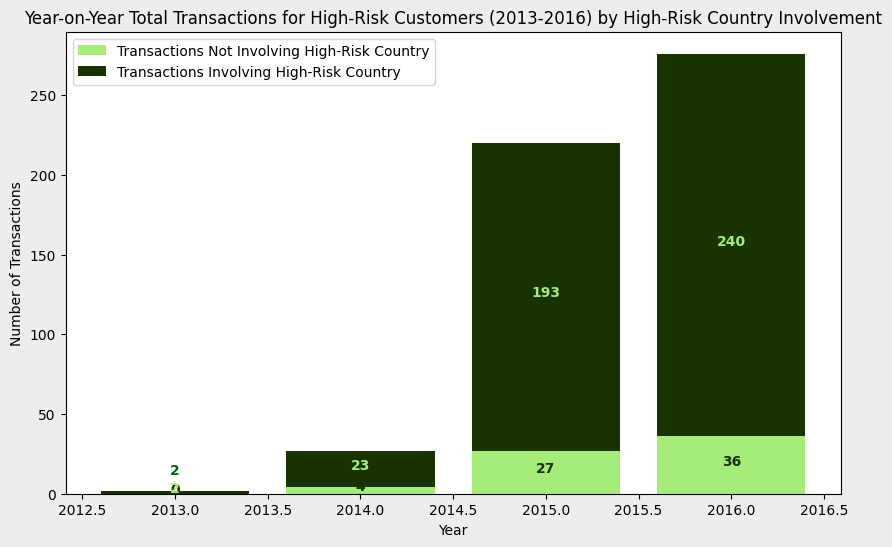

In [15]:
# Filter transactions for high-risk customers only
high_risk_customers_transactions = data[data['customer_risk_factor'] == "High"]

# Extract year from `date_request_submitted` and add as a new column
high_risk_customers_transactions['Year'] = pd.to_datetime(high_risk_customers_transactions['date_request_submitted'], format="%d/%m/%Y %H:%M").dt.year

# Filter for years 2013 to 2016
high_risk_customers_transactions = high_risk_customers_transactions[high_risk_customers_transactions['Year'].between(2013, 2016)]

# Determine if the transaction involves a high-risk country as sender or receiver
high_risk_customers_transactions['Involves_High_Risk_Country'] = (
    high_risk_customers_transactions['addr_country_code'].isin(high_risk_countries) |
    high_risk_customers_transactions['recipient_country_code'].isin(high_risk_countries)
)

# Group by year to calculate counts of transactions involving high-risk countries and total transactions
summary = high_risk_customers_transactions.groupby('Year').agg(
    Total_Transactions=('user_id', 'size'),
    High_Risk_Country_Transactions=('Involves_High_Risk_Country', 'sum')
).reset_index()

# Calculate transactions not involving high-risk countries
summary['Non_High_Risk_Country_Transactions'] = summary['Total_Transactions'] - summary['High_Risk_Country_Transactions']

# Plotting the stacked bar chart
plt.figure(figsize=(10, 6), facecolor="#ECEEEB")  # Chart background color

# Plot the bars
bars1 = plt.bar(summary['Year'], summary['Non_High_Risk_Country_Transactions'], color="#A5EC78", label="Transactions Not Involving High-Risk Country")  # Light green
bars2 = plt.bar(summary['Year'], summary['High_Risk_Country_Transactions'],
                bottom=summary['Non_High_Risk_Country_Transactions'], color="#183300", label="Transactions Involving High-Risk Country")  # Dark green

# Add data labels
for bar1, bar2, total, year in zip(bars1, bars2, summary['Total_Transactions'], summary['Year']):
    # Dark green text inside light green bars
    plt.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height() / 2, int(bar1.get_height()), ha='center', color="#183300", fontweight="bold")
    # Light green text inside dark green bars
    plt.text(bar2.get_x() + bar2.get_width() / 2, bar1.get_height() + bar2.get_height() / 2, int(bar2.get_height()), ha='center', color="#A5EC78", fontweight="bold")
    # For 2013, display total value on top of the bar with a gap
    if year == 2013:
        plt.text(bar2.get_x() + bar2.get_width() / 2, total + 10, int(total), ha='center', color="#006400", fontweight="bold")

# Customize chart appearance
plt.xlabel("Year")
plt.ylabel("Number of Transactions")
plt.title("Year-on-Year Total Transactions for High-Risk Customers (2013-2016) by High-Risk Country Involvement")
plt.legend()
plt.grid(False)  # Remove gridlines

# Show the plot
plt.show()


6. Account age distribution for high-risk customers

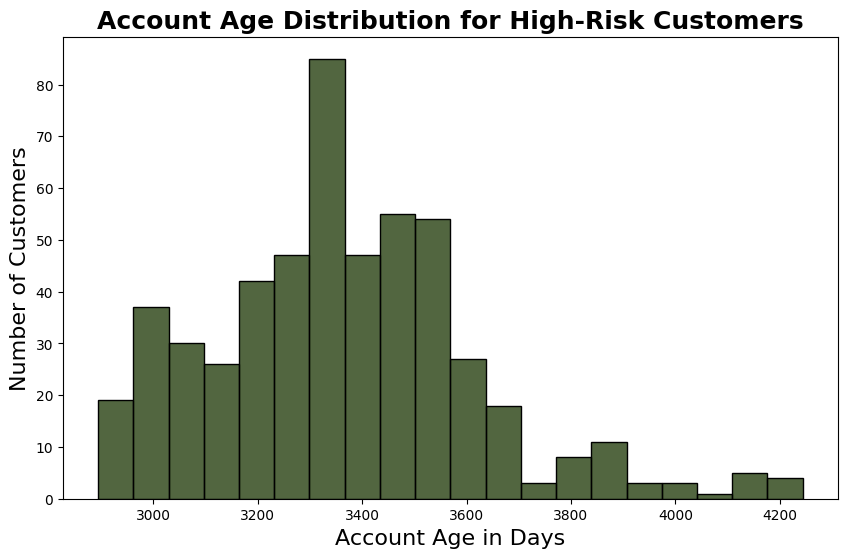

In [16]:
# Plot distribution of account age for high-risk customers
plt.figure(figsize=(10, 6))
sns.histplot(data[data['customer_risk_factor'] == 'High']['days_account_created'], bins=20, color='#183300')
plt.title("Account Age Distribution for High-Risk Customers", fontdict={'size': 18, 'weight': 'bold'})
plt.xlabel("Account Age in Days", fontdict={'size': 16})
plt.ylabel("Number of Customers", fontdict={'size': 16})
plt.show()


7. Distribution of High_risk Transactions by Transfer Sequence

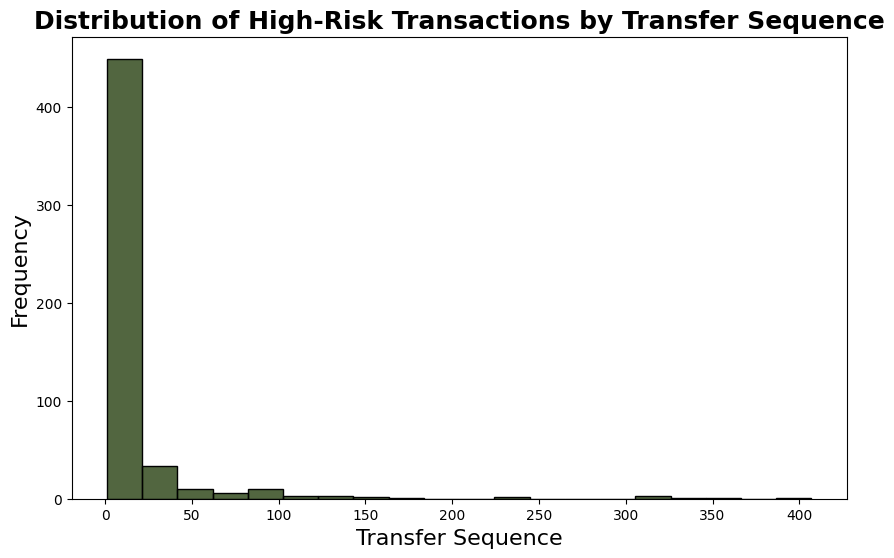

In [17]:
# Filter high-risk customer and plot distribution of transfer sequence
plt.figure(figsize=(10, 6))
sns.histplot(
    data[data['customer_risk_factor'] == 'High']['transfer_sequence'],
    bins=20,
    color='#183300',
    kde=False
)
plt.title("Distribution of High-Risk Transactions by Transfer Sequence", fontdict={'size': 18, 'weight': 'bold'})
plt.xlabel("Transfer Sequence", fontdict={'size': 16})
plt.ylabel("Frequency", fontdict={'size': 16})
plt.show()


8. High-Risk Transactions by Day of the Week

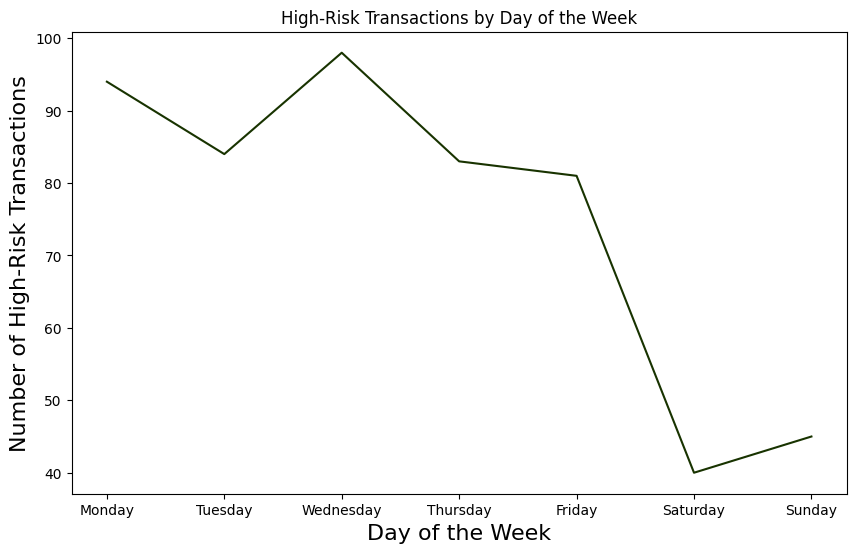

In [18]:
# Ensure 'date_request_submitted' is in datetime format
data['date_request_submitted'] = pd.to_datetime(data['date_request_submitted'], errors='coerce', format="%d/%m/%Y %H:%M")

# Extract the day of the week from the transaction date
data['DayOfWeek'] = data['date_request_submitted'].dt.day_name()

# Filter for high-risk transactions and count by day of the week
day_of_week_counts = data[data['customer_risk_factor'] == 'High']['DayOfWeek'].value_counts()

# Reindex the counts to ensure ordering from Monday to Sunday
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_of_week_counts = day_of_week_counts.reindex(day_order)

# Plot bar chart for high-risk transactions by day of the week
plt.figure(figsize=(10, 6))
day_of_week_counts.plot(kind='line', color='#183300')
plt.title("High-Risk Transactions by Day of the Week")
plt.xlabel("Day of the Week", fontdict={'size': 16})
plt.ylabel("Number of High-Risk Transactions", fontdict={'size': 16})
plt.show()


9. Average Time Between Requests for High-Risk Users

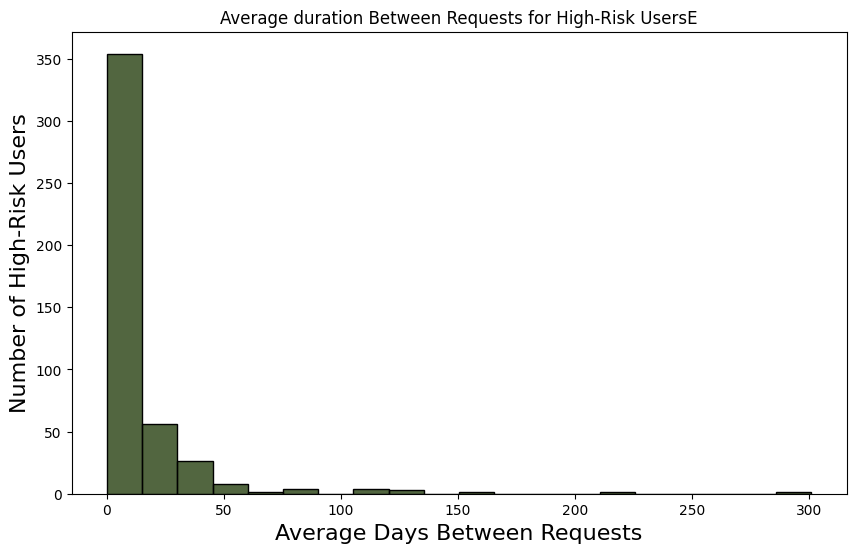

In [19]:
# Calculate the average time in days between requests for each high-risk user
time_between_requests = data[data['customer_risk_factor'] == 'High'].groupby('user_id')['days_since_previous_req'].mean()

# Plot distribution of time between requests
plt.figure(figsize=(10, 6))
sns.histplot(time_between_requests, bins=20, color='#183300')
plt.title("Average duration Between Requests for High-Risk UsersE")
plt.xlabel("Average Days Between Requests", fontdict={'size': 16})
plt.ylabel("Number of High-Risk Users", fontdict={'size': 16})
plt.show()


10. High-Risk Transactions by Hour of the Day

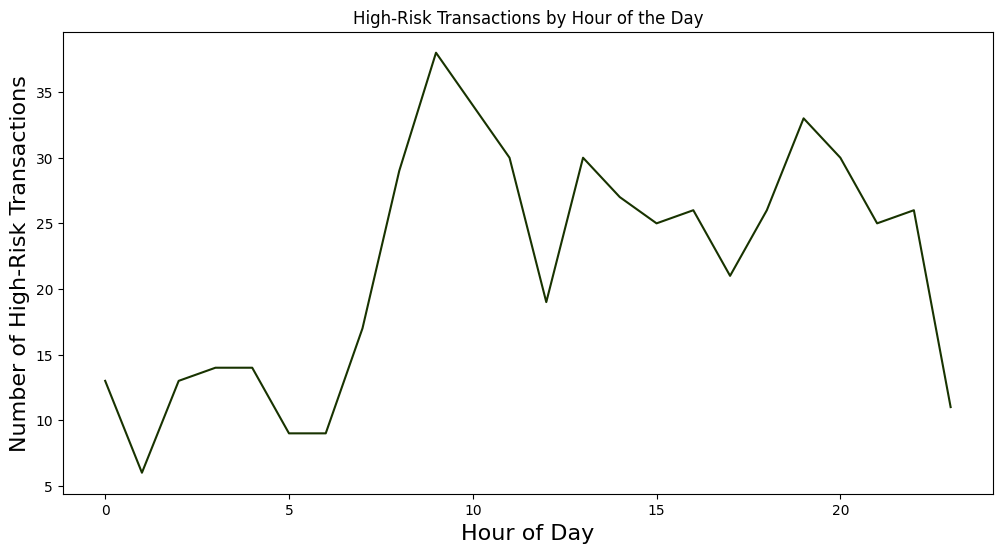

In [20]:
# Extract hour of transaction from date
data['Hour'] = data['date_request_submitted'].dt.hour

# Filter for high-risk transactions and count by hour
hourly_counts = data[data['customer_risk_factor'] == 'High']['Hour'].value_counts().sort_index()

# Plot line chart for high-risk transactions by hour
plt.figure(figsize=(12, 6))
hourly_counts.plot(kind='line', color='#183300')
plt.title("High-Risk Transactions by Hour of the Day")
plt.xlabel("Hour of Day",  fontdict={'size': 16})
plt.ylabel("Number of High-Risk Transactions",  fontdict={'size': 16})
plt.show()


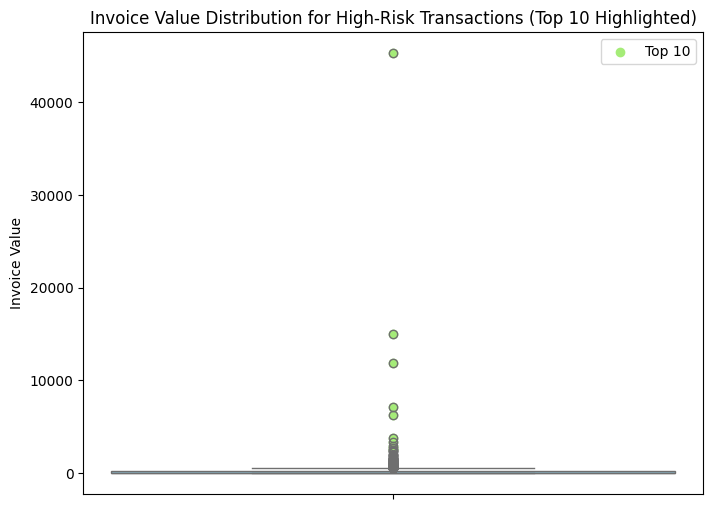

In [24]:
# Define top 10 high-risk transactions by invoice value
top_invoice_values = data[data['customer_risk_factor'] == 'High'][['invoice_value']].nlargest(10, 'invoice_value')

# Plotting the boxplot and highlighting the top 10 values
plt.figure(figsize=(8, 6))
sns.boxplot(data=data[data['customer_risk_factor'] == 'High'], y='invoice_value', color='skyblue')
plt.scatter([0]*len(top_invoice_values), top_invoice_values['invoice_value'], color='#A5EC78', label="Top 10")
plt.title("Invoice Value Distribution for High-Risk Transactions (Top 10 Highlighted)")
plt.ylabel("Invoice Value")
plt.legend()
plt.show()


Percentage of high-risk customers who sent money to high-risk countries and have 'Other/unknown' in sending bank details:

In [25]:
# Define high-risk countries

# Filter for high-risk customers involving a high-risk country and with "Other/unknown" in bank fields
high_risk_condition = (
    (data['customer_risk_factor'] == 'High') &
    ((data['recipient_country_code'].isin(high_risk_countries)) | (data['addr_country_code'].isin(high_risk_sender_countries))) &
    ((data['sending_bank_name'] == "Other/unknown") | (data['sending_bank_country'] == "Other/unknown"))
)

# Calculate percentage
high_risk_customers_count = data[high_risk_condition].shape[0]
total_high_risk_customers = data[data['customer_risk_factor'] == 'High'].shape[0]
percentage_high_risk = (high_risk_customers_count / total_high_risk_customers) * 100

print(f"Percentage of high-risk customers involving a high-risk country with 'Other/unknown' in bank fields: {percentage_high_risk:.2f}%")
print(f"Count high-risk customers involving a high-risk country with 'Other/unknown' in bank fields: {high_risk_customers_count}")

Percentage of high-risk customers involving a high-risk country with 'Other/unknown' in bank fields: 90.10%
Count high-risk customers involving a high-risk country with 'Other/unknown' in bank fields: 473


Total number of unique customers inside dropped_bak_cln.csv

In [26]:
# Calculate the total number of unique customers
total_unique_customers = dropped_data['user_id'].nunique()

print(f"Total number of unique customers: {total_unique_customers}")


Total number of unique customers: 962


Percentage of Low-risk customers who sent money to high-risk countries and have 'Other/unknown' in sending bank details:

In [27]:
# Define high-risk countries

# Filter for high-risk customers involving a high-risk country and with "Other/unknown" in bank fields
high_risk_condition = (
    (data['customer_risk_factor'] == 'Low') &
    ((data['recipient_country_code'].isin(high_risk_countries)) | (data['addr_country_code'].isin(high_risk_sender_countries))) &
    ((data['sending_bank_name'] == "Other/unknown") | (data['sending_bank_country'] == "Other/unknown"))
)

# Calculate percentage
high_risk_customers_count = data[high_risk_condition].shape[0]
total_high_risk_customers = data[data['customer_risk_factor'] == 'Low'].shape[0]
percentage_high_risk = (high_risk_customers_count / total_high_risk_customers) * 100

print(f"Percentage of high-risk customers involving a high-risk country with 'Other/unknown' in bank fields: {percentage_high_risk:.2f}%")
print(f"Count high-risk customers involving a high-risk country with 'Other/unknown' in bank fields: {high_risk_customers_count}")

Percentage of high-risk customers involving a high-risk country with 'Other/unknown' in bank fields: 0.03%
Count high-risk customers involving a high-risk country with 'Other/unknown' in bank fields: 28


Percentage of Medium-risk customers who sent money to high-risk countries and have 'Other/unknown' in sending bank details:

In [28]:
# Define high-risk countries


# Filter for high-risk customers involving a high-risk country and with "Other/unknown" in bank fields
high_risk_condition = (
    (data['customer_risk_factor'] == 'Medium') &
    ((data['recipient_country_code'].isin(high_risk_countries)) | (data['addr_country_code'].isin(high_risk_sender_countries))) &
    ((data['sending_bank_name'] == "Other/unknown") | (data['sending_bank_country'] == "Other/unknown"))
)

# Calculate percentage
high_risk_customers_count = data[high_risk_condition].shape[0]
total_high_risk_customers = data[data['customer_risk_factor'] == 'Medium'].shape[0]
percentage_high_risk = (high_risk_customers_count / total_high_risk_customers) * 100

print(f"Percentage of high-risk customers involving a high-risk country with 'Other/unknown' in bank fields: {percentage_high_risk:.2f}%")
print(f"Count high-risk customers involving a high-risk country with 'Other/unknown' in bank fields: {high_risk_customers_count}")

Percentage of high-risk customers involving a high-risk country with 'Other/unknown' in bank fields: 15.45%
Count high-risk customers involving a high-risk country with 'Other/unknown' in bank fields: 1234
